In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from Chandra.Time import DateTime, convert
import os
import re
from datetime import datetime
from glob import glob
import Ska.arc5gl
from Ska.Shell import getenv, bash, Spawn
from astropy.io import fits, ascii
from astropy.table import Table
import logging
from scipy.optimize import curve_fit
from matplotlib  import cm
from Ska.Matplotlib import plot_cxctime#, cxctime2plotdate, set_time_ticks
import mpld3
import pandas as pd

In [499]:
NUM_FIT_SRC = 10
SNR_FIT_LIM = 6

def plot_all_sources(sources, instrument):
    """
    """
    flt = sources['INSTRUME'] == instrument
    plt.scatter(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], color='lightgray',
                alpha=0.1, label='All')
    plt.xlabel('off-axis distance (arcsec)')
    plt.ylabel('PSF (arcsec)')
    plt.title('ACIS-S, SNR > 15')
    plt.grid(ls='--')
    
    
def get_obsid_counter(sources):
    """
    """
    obsids = np.unique(sources['OBS_ID'])
    obsid_counter = {'obsid': [], 'counter': [], 'instrume': []}
    for obsid in obsids:
        flt = sources['OBS_ID'] == obsid
        obsid_counter['obsid'].append(obsid)
        obsid_counter['counter'].append(np.sum(flt))
        obsid_counter['instrume'].append(sources['INSTRUME'][flt][0])

    obsid_counter = Table(obsid_counter)
    return obsid_counter


def psf_function_a0(x, a0):
    """
    Fit only for a0 (on-axis PSF)
    """
    return a0 + COEFF1 * x + COEFF2 * x**2


def psf_function(x, a0, a1, a2):
    """
    Fit for all coefficients
    """
    return a0 + a1 * x + a2 * x**2


def fit_psf_per_obsid(sources):
    """
    """
    psf_models = {'obsid': [], 'instrument': [], 'on_axis': [],
                 'a0': [], 'a1': [], 'a2': [], 'pcov': []}

    obsids = np.unique(sources['OBS_ID'])
    for obsid in obsids:
        flt = (sources['OBS_ID'] == obsid) & (sources['SNR'] > SNR_FIT_LIM)

        if len(sources[flt]) < NUM_FIT_SRC:
            continue
    
        x = sources['DIST_ARCSEC'][flt]
        y = sources['PSF_ARCSEC'][flt]
        popt, pcov = curve_fit(psf_function, x, y)

        instrument = sources['INSTRUME'][flt][0]
        color = psf_color[instrument]
    
        psf_models['obsid'].append(obsid)
        psf_models['a0'].append(popt[0])
        psf_models['a1'].append(popt[1])
        psf_models['a2'].append(popt[2])
        psf_models['pcov'].append(pcov)
        psf_models['instrument'].append(instrument)
        on_axis = psf_function(np.arange(0, 1), *popt)[0]
        psf_models['on_axis'].append(on_axis)
        
    return psf_models
    
        
def plot_psf_per_obsid(sources, psf_model, year):
    """
    """
    fig = plt.figure(figsize=(12, 5))
    fig.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9,
                        hspace=0.15, wspace=0.15)

    plt.scatter(sources['DIST_ARCSEC'], sources['PSF_ARCSEC'], color='lightgray',
                alpha=0.3, label='All')
    plt.xlabel('off-axis distance (arcsec)', labelpad=10)
    plt.ylabel('PSF (arcsec)', labelpad=20)
    plt.title(f'Year = {year}, SNR > {SNR_FIT_LIM}, N_SOURCES > {NUM_FIT_SRC}')
    plt.grid(ls='--')
    
    psf_color = {'ACIS-S': 'crimson', 'ACIS-I': 'saddlebrown',
                 'HRC-I': 'steelblue', 'HRC-S': 'forestgreen'}

    for model in psf_models:
        flt = sources['OBS_ID'] == model['obsid']
        x = sources['DIST_ARCSEC'][flt]
        popt = [model['a0'], model['a1'], model['a2']]
        color = psf_color[model['instrument']]
        points = plt.plot(x, psf_function(x, *popt), 'k', lw=2, color=color)

    return fig, points
    
    
def get_median_on_axis_psf(psf_models):
    """
    """
    for instrument in ('ACIS-S', 'ACIS-I', 'HRC-S', 'HRC-I'):
        flt = psf_models['instrument'] == instrument
        on_axis = None
        nn = len(psf_models[flt])
        if nn > 0:
            on_axis = np.median(psf_models['on_axis'][flt])
        print(f'{instrument}, {nn} observations, median on-axis PSF = {on_axis} arcsec')        

## Interactive plotting with mpld3 ##

In [508]:
sources = ascii.read('2016/hrma_focus_house_keeping.txt')
sources.sort('DIST_ARCSEC')

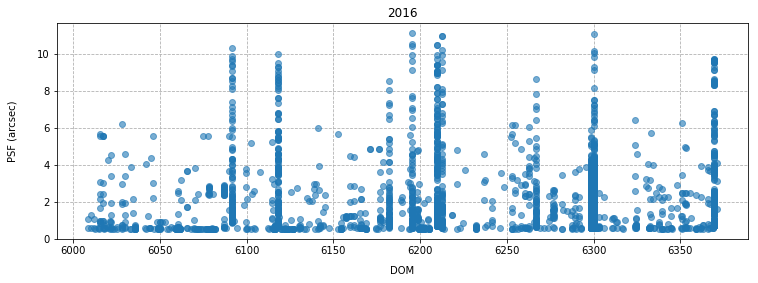

In [509]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9,
                    hspace=0.15, wspace=0.15)
flt = sources['INSTRUME'] == 'ACIS-S'
dat = sources[flt]

times = DateTime(dat['TSTART'])  - DateTime('1999:204')
points = plt.plot(times, dat['PSF_ARCSEC'], 'o', alpha=0.6)
plt.title('2016')
plt.xlabel('DOM', labelpad=10)
plt.ylabel('PSF (arcsec)', labelpad=20)
plt.grid(ls='--')

# labels = [f'ObsID {obsid}' for obsid in dat['OBS_ID']]
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
# mpld3.plugins.connect(fig, tooltip)
# mpld3.display()
# mpld3.save_html(fig, '2016/2016_psf_vs_time.html')

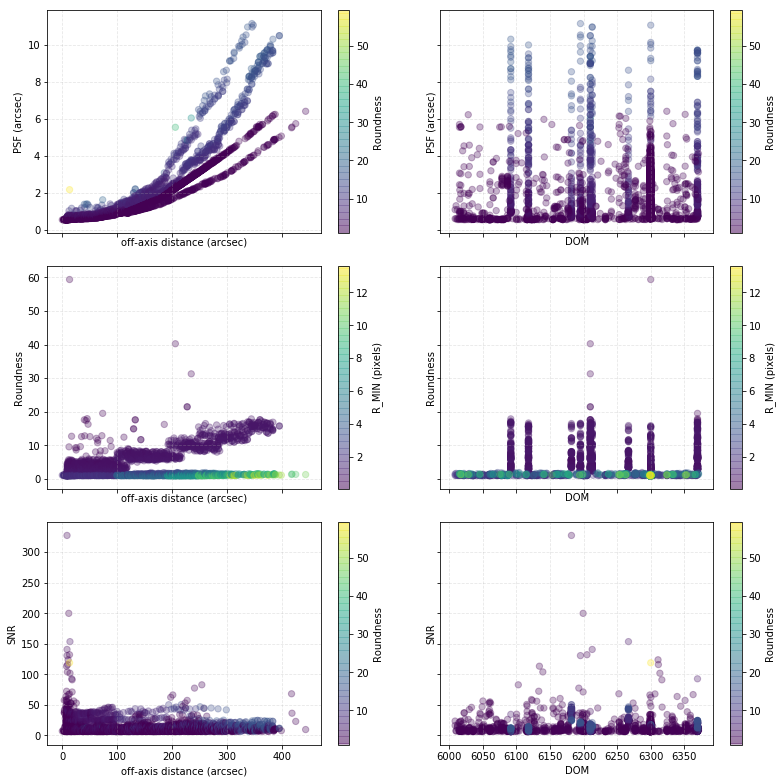

In [516]:
fig, ax = plt.subplots(3, 2, sharex="col", sharey="row", figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95,
                    hspace=0.15, wspace=0.15)

# Days since 1999:204 (DOM)
times = DateTime(dat['TSTART']) - DateTime('1999:204')
dt = DateTime(dat['TSTOP']) - DateTime(dat['TSTART'])

kwargs = {'s': 40, 'alpha': 0.3}

x_axis = (dat['DIST_ARCSEC'], times)
x_labels = ('off-axis distance (arcsec)', 'DOM')
y_axis = (dat['PSF_ARCSEC'], dat['RNDS'], dat['SNR'])
y_labels = ('PSF (arcsec)', 'Roundness', 'SNR')
c_axis = (dat['RNDS'], dat['RMIN'], dat['RNDS'])
c_labels = ('Roundness', 'R_MIN (pixels)', 'Roundness')

for i in range(2):
    for j in range(3):
        points = ax[j, i].scatter(x_axis[i], y_axis[j], c=c_axis[j], **kwargs)
        ax[j, i].set_xlabel(x_labels[i])
        ax[j, i].set_ylabel(y_labels[j])
        cbar = plt.colorbar(points, ax=ax[j, i])
        cbar.set_label(c_labels[j])
        ax[j, i].grid(ls='--', alpha=0.3)

# Here we connect the linked brush plugin
# mpld3.plugins.connect(fig, mpld3.plugins.LinkedBrush(points))
# mpld3.display()  # Display in notebook doesn't work with large data set
# mpld3.save_html(fig, '2016/2016_exploration.html')

### Identify observations with many source detections ###

In [335]:
obsid_counter = get_obsid_counter(sources)

In [336]:
obsid_counter.sort('counter')
for instrument in ('ACIS-S', 'ACIS-I', 'HRC-S', 'HRC-I'):
    flt = (obsid_counter['instrume'] == instrument)
    print(obsid_counter[flt][-5:])

obsid counter instrume
----- ------- --------
18015     152   ACIS-S
18016     173   ACIS-S
18017     252   ACIS-S
19903     379   ACIS-S
18344     398   ACIS-S
obsid counter instrume
----- ------- --------
17240      19   ACIS-I
17523      28   ACIS-I
18047      30   ACIS-I
18453      44   ACIS-I
17743      54   ACIS-I
obsid counter instrume
----- ------- --------
18376       2    HRC-S
18375       2    HRC-S
18366       3    HRC-S
18385       3    HRC-S
17770       9    HRC-S
obsid counter instrume
----- ------- --------
19793      15    HRC-I
16667      20    HRC-I
17896      30    HRC-I
18608      39    HRC-I
18609      39    HRC-I


### Exploration of the 2016 dataset ###

In [44]:
min(DateTime(sources['TSTART']).date), max(DateTime(sources['TSTART']).date)

('2016:004:04:00:05.346', '2016:366:12:05:50.164')

In [43]:
sources.colnames

['X',
 'Y',
 'SNR',
 'RMAJ',
 'RMIN',
 'ROTANG',
 'PSFRATIO',
 'NET_COUNTS',
 'OBS_ID',
 'TSTART',
 'TSTOP',
 'FP_TEMP',
 'RA_NOM',
 'DEC_NOM',
 'ROLL_NOM',
 'DEFOCUS',
 'SIM_X',
 'SIM_Y',
 'SIM_Z',
 'INSTRUME',
 'RNDS',
 'RAVG',
 'PSF',
 'DIST',
 'PSF_ARCSEC',
 'DIST_ARCSEC',
 'ANGDIST']

In [520]:
HOUSE_KEEPING_FILE = '2016/hrma_focus_house_keeping.txt'
sources = ascii.read(HOUSE_KEEPING_FILE)
sources.sort('DIST_ARCSEC')
dt = sources['TSTOP'] - sources['TSTART']
rate = sources['NET_COUNTS'] / dt

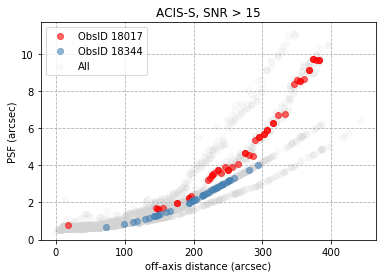

In [523]:
# All ACIS-S sources
plot_all_sources(sources, 'ACIS-S')

# Two obsids forming two different branches
obsid = 18017
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['OBS_ID'] == obsid) & (sources['SNR'] > 15)
plt.plot(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], 'o',
         alpha=0.6, color='red', label='ObsID 18017')

obsid = 18344
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['OBS_ID'] == obsid) & (sources['SNR'] > 15)
plt.plot(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], 'o',
         alpha=0.6, color='steelblue', label='ObsID 18344')

plt.legend();

__Figure:__ Sources detected in a given observation do not 'jump' between the traces in a PSF vs. distance plot. The underlying reason for various traces has to do with the s/c conditions (pitch? temp?) rather than properties of individual sources (SNR, number of counts, distance, etc). Should we fit each obsid separately?

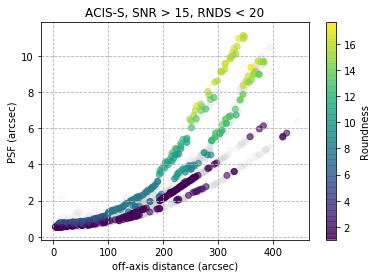

In [524]:
# All ACIS-S sources
plot_all_sources(sources, 'ACIS-S')

# Filtering by Roundness
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['RNDS'] < 20) & (sources['SNR'] > 15)
plt.scatter(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], c=sources['RNDS'][flt],
            alpha=0.6)
cbar = plt.colorbar()
cbar.set_label('Roundness')
plt.title('ACIS-S, SNR > 15, RNDS < 20');

In [347]:
imax = np.argmax(sources['RNDS'][flt1])
sources['RNDS'][flt1][imax], sources['RMAJ'][flt1][imax], sources['RMIN'][flt1][imax]

(59.331680297851562, 1.9761760234832764, 0.033307265490293503)

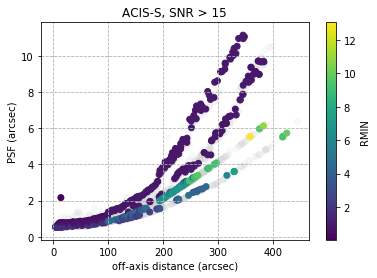

In [525]:
# All ACIS-S sources
plot_all_sources(sources, 'ACIS-S')

# RMIN?
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['SNR'] > 15)
plt.scatter(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], c=sources['RMIN'][flt])
plt.grid(ls='--')
cbar = plt.colorbar()
cbar.set_label('RMIN')

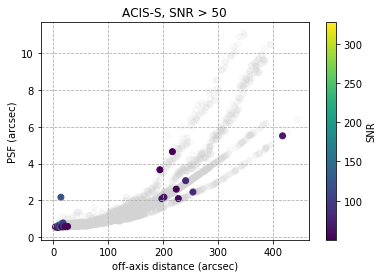

In [526]:
# All ACIS-S sources
plot_all_sources(sources, 'ACIS-S')

# SNR?
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['SNR'] > 50)
plt.scatter(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], c=sources['SNR'][flt])
plt.grid(ls='--')
cbar = plt.colorbar()
cbar.set_label('SNR')
plt.title('ACIS-S, SNR > 50');

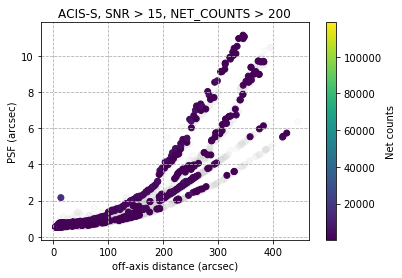

In [528]:
# All ACIS-S sources
plot_all_sources(sources, 'ACIS-S')

# NET_COUNTS?
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['SNR'] > 15) & (sources['NET_COUNTS'] > 200)
plt.scatter(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], c=sources['NET_COUNTS'][flt])
plt.grid(ls='--')
cbar = plt.colorbar()
cbar.set_label('Net counts')
plt.title('ACIS-S, SNR > 15, NET_COUNTS > 200');

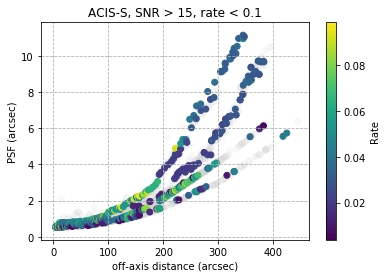

In [529]:
# All ACIS-S sources
plot_all_sources(sources, 'ACIS-S')

# rate?
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['SNR'] > 15) & (rate < 0.1)
plt.scatter(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], c=rate[flt])
plt.grid(ls='--')
cbar = plt.colorbar()
cbar.set_label('Rate')
plt.title('ACIS-S, SNR > 15, rate < 0.1');

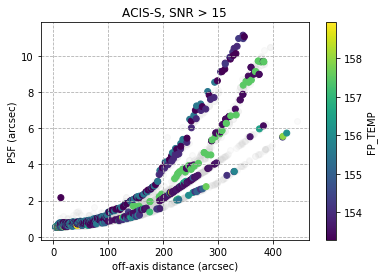

In [530]:
# All ACIS-S sources
plot_all_sources(sources, 'ACIS-S')

# FP_TEMP?
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['SNR'] > 15)
plt.scatter(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], c=sources['FP_TEMP'][flt])
plt.grid(ls='--')
cbar = plt.colorbar()
cbar.set_label('FP_TEMP')

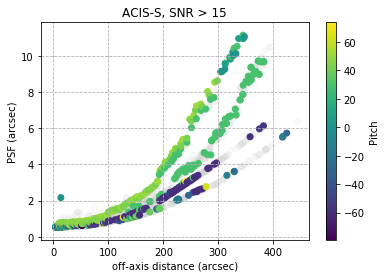

In [531]:
# All ACIS-S sources
plot_all_sources(sources, 'ACIS-S')

# Pitch?
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['SNR'] > 15)
plt.scatter(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], c=-sources['DEC_NOM'][flt])
plt.grid(ls='--')
cbar = plt.colorbar()
cbar.set_label('Pitch')

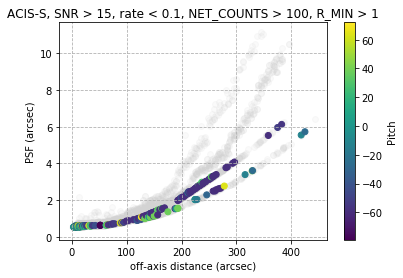

In [533]:
# All ACIS-S sources
plot_all_sources(sources, 'ACIS-S')

# 
flt = (sources['INSTRUME'] == 'ACIS-S') & (sources['SNR'] > 15) & \
      (rate < 0.1) * (sources['NET_COUNTS'] > 100) & (sources['RMIN'] > 1)
plt.scatter(sources['DIST_ARCSEC'][flt], sources['PSF_ARCSEC'][flt], c=-sources['DEC_NOM'][flt])
plt.grid(ls='--')
cbar = plt.colorbar()
cbar.set_label('Pitch')
plt.title('ACIS-S, SNR > 15, rate < 0.1, NET_COUNTS > 100, R_MIN > 1');

## 2016 - fit each ObsID ##

In [558]:
year = 2016

In [559]:
HOUSE_KEEPING_FILE = f'{year}/hrma_focus_house_keeping.txt'
sources = ascii.read(HOUSE_KEEPING_FILE)
sources.sort('DIST_ARCSEC')

In [560]:
psf_models = fit_psf_per_obsid(sources)
psf_models = Table(psf_models)

In [561]:
get_median_on_axis_psf(psf_models)

ACIS-S, 28 observations, median on-axis PSF = 0.6078878393815964 arcsec
ACIS-I, 29 observations, median on-axis PSF = 0.6079078709607275 arcsec
HRC-S, 0 observations, median on-axis PSF = None arcsec
HRC-I, 5 observations, median on-axis PSF = -2.13448523579447 arcsec


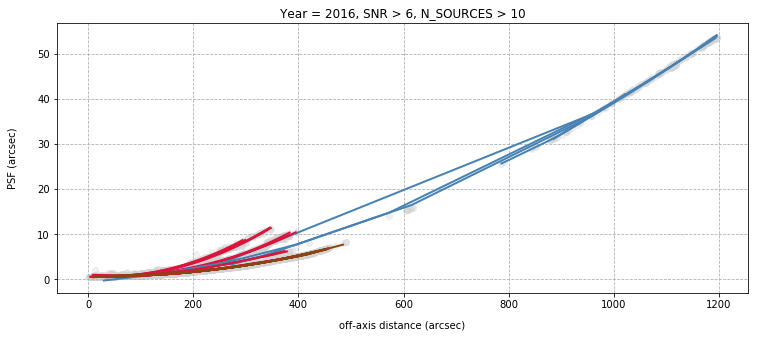

In [562]:
plot_psf_per_obsid(sources, psf_models, year=year)
mpld3.save_html(fig, f'{year}/{year}_fit_psf.html')
# mpld3.display()

## 2017 ##

In [548]:
year = 2017

In [549]:
HOUSE_KEEPING_FILE = f'{year}/hrma_focus_house_keeping.txt'
sources = ascii.read(HOUSE_KEEPING_FILE)
sources.sort('DIST_ARCSEC')

In [550]:
psf_models = fit_psf_per_obsid(sources)
psf_models = Table(psf_models)

In [551]:
get_median_on_axis_psf(psf_models)

ACIS-S, 20 observations, median on-axis PSF = 0.6318791446144041 arcsec
ACIS-I, 10 observations, median on-axis PSF = 0.6269114725670706 arcsec
HRC-S, 0 observations, median on-axis PSF = None arcsec
HRC-I, 12 observations, median on-axis PSF = -2.211468257268563 arcsec


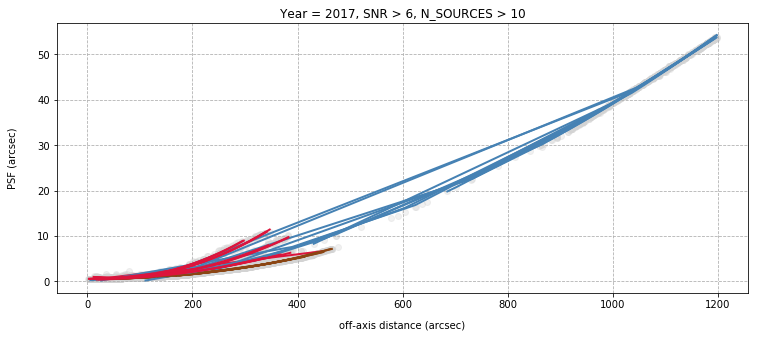

In [552]:
fig, points = plot_psf_per_obsid(sources, psf_models, year=year)
mpld3.save_html(fig, f'{year}/{year}_fit_psf.html')
# mpld3.display()

## 2000 ##

In [573]:
year = 2000

In [574]:
HOUSE_KEEPING_FILE = f'{year}/hrma_focus_house_keeping.txt'
sources = ascii.read(HOUSE_KEEPING_FILE)
sources.sort('DIST_ARCSEC')

In [575]:
psf_models = fit_psf_per_obsid(sources)
psf_models = Table(psf_models)

In [576]:
get_median_on_axis_psf(psf_models)

ACIS-S, 83 observations, median on-axis PSF = 0.6006673746150031 arcsec
ACIS-I, 61 observations, median on-axis PSF = 0.6183589952563876 arcsec
HRC-S, 0 observations, median on-axis PSF = None arcsec
HRC-I, 10 observations, median on-axis PSF = -0.12952162124950328 arcsec


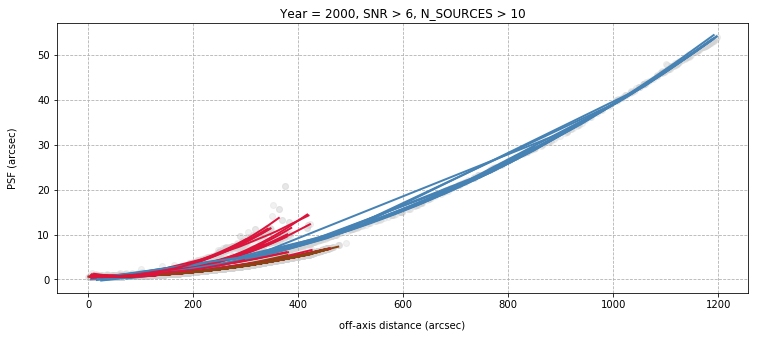

In [577]:
fig, points = plot_psf_per_obsid(sources, psf_models, year=year)
mpld3.save_html(fig, f'{year}/{year}_fit_psf.html')
# mpld3.display()